# PyTorch Image Classifier
- Reference: https://colab.research.google.com/github/bentoml/gallery/blob/master/pytorch/cifar10-image-classification/pytorch-cifar10-image-classification.ipynb
- 조교: 이정수 (bebeto@kaist.ac.kr)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install -q bentoml "torch==1.6.0" "torchvision==0.7.0" "pillow==7.2.0"


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

# Training an image classifier

We will do the following steps in order:

* Load and normalizing the MNIST training and test datasets using torchvision
* Define a Convolutional Neural Network
* Define a loss function
* Train the network on the training data
* Test the network on the test data
* Model Serving with BentoML


## 1 Loading and Normalizing MNIST

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Let us show some of the training images, for fun.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img scale min: -1.0 max: 1.0


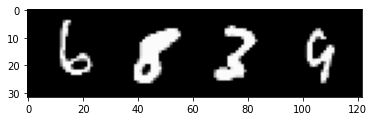

img scale min: 0.0 max: 1.0


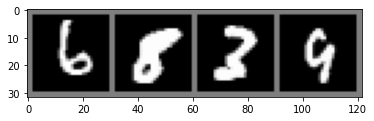

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

# scale에 따른 시각화차이를 보여주기 위함
def imshow(img):
    print(f'img scale min: {img.min()} max: {img.max()}')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    plt.close()

    img = img / 2 + 0.5     # unnormalize 
    print(f'img scale min: {img.min()} max: {img.max()}')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## 2 Define a Convolutional Neural Network

Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# MLP (Multi Layer Perceptron)

In [7]:
class MLP(nn.Module):
    def __init__(self, num_classes = 10):
        super(MLP, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 16),
            nn.ReLU()
        )
        self.classifier = nn.Linear(16, num_classes)


    def forward(self, x, mode=None, return_feat=False):
        x = x.view(x.size(0), -1) 
        x = self.feature(x)
        x = self.classifier(x)
        return x 

# ResNet

In [8]:
net = MLP().cuda()

## 3 Define a Loss function and optimize

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

## 4 Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [10]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.974
[1,  4000] loss: 0.527
[1,  6000] loss: 0.436
[1,  8000] loss: 0.388
[1, 10000] loss: 0.344
[1, 12000] loss: 0.333
[1, 14000] loss: 0.314
Finished Training


## 5 Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img scale min: -1.0 max: 1.0


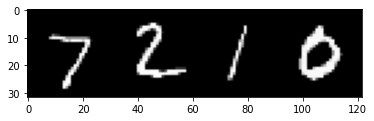

img scale min: 0.0 max: 1.0


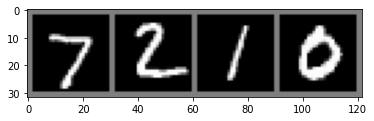

In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))

Let us look at how the network performs on the whole dataset.

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 92 %
